In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
print(tf.__version__)

import os


2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [ ]:
train_path = '/content/drive/MyDrive/PlantVillage'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE )

Found 1588 files belonging to 16 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Corn_Blight',
 'Corn_crop',
 'Corn_healthy',
 'Nitrogen deficiency in plant',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice leaf_Bacterial leaf blight',
 'Rice leaf_Brown spot',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Tomato_healthy',
 'potassium deficiency in plant',
 'potato crop']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 0  4  5  8  4  6 13  2  8  8 13  2 12 14 13  7 13 13 14 10  4 13 12 13
 15  1 10 15  1  9  6 15]


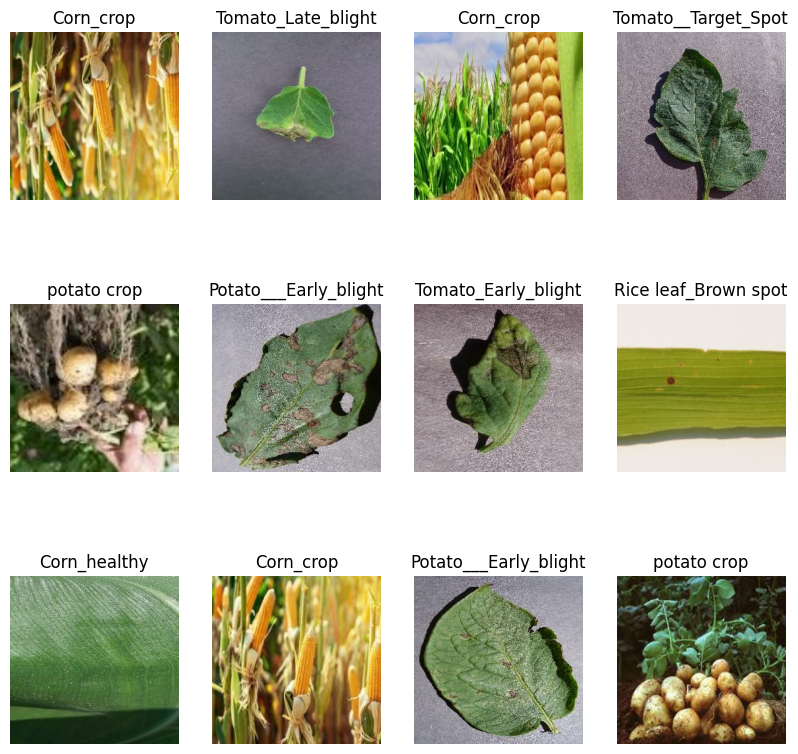

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# Function to Split Dataset
# Dataset should be bifurcated into 3 subsets, namely:

# Training: Dataset to be used while training
# Validation: Dataset to be tested against while training
# Test: Dataset to be tested against after we trained a model

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

40

In [ ]:
len(val_ds)

5

In [ ]:
len(test_ds)

5

In [ ]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Building the Model
# Creating a Layer for Resizing and Normalization
# Before we feed our images to network, we should be resizing it to the desired size.
# Moreover, to improve model performance, we should normalize the image pixel value
# (keeping them in range 0 and 1 by dividing by 256).
# This should happen while training as well as inference.
# Hence we can add that as a layer in our Sequential Model.

# You might be thinking why do we need to resize (256,256) image to again (256,256).
# You are right we don't need to but this will be useful when we are done with the training
# and start using the model for predictions.
# At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Data Augmentation
# Data Augmentation is needed when we have less data,
# this boosts the accuracy of our model by augmenting the data

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Applying Data Augmentation to Train Dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Model Architecture
# We use a CNN coupled with a Softmax activation in the output layer.
# We also add the initial layers for resizing, normalization and Data Augmentation.

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 16

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
# Compiling the Model
# We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
40/40 [==============================] - 274s 522ms/step - loss: 2.7021 - accuracy: 0.0953 - val_loss: 2.5616 - val_accuracy: 0.0878
Epoch 2/100
40/40 [==============================] - 12s 308ms/step - loss: 2.4581 - accuracy: 0.1414 - val_loss: 2.2910 - val_accuracy: 0.1757
Epoch 3/100
40/40 [==============================] - 11s 286ms/step - loss: 2.3009 - accuracy: 0.1852 - val_loss: 2.1964 - val_accuracy: 0.2500
Epoch 4/100
40/40 [==============================] - 11s 283ms/step - loss: 2.1815 - accuracy: 0.2492 - val_loss: 2.0268 - val_accuracy: 0.2432
Epoch 5/100
40/40 [==============================] - 12s 306ms/step - loss: 1.9454 - accuracy: 0.3133 - val_loss: 1.7081 - val_accuracy: 0.3851
Epoch 6/100
40/40 [==============================] - 12s 304ms/step - loss: 1.6839 - accuracy: 0.4016 - val_loss: 1.4121 - val_accuracy: 0.5068
Epoch 7/100
40/40 [==============================] - 12s 303ms/step - loss: 1.6895 - accuracy: 0.4297 - val_loss: 1.4013 - val_accuracy

In [ ]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 7s 31ms/step - loss: 0.1893 - accuracy: 0.9312


In [ ]:
scores
#lost and accuracy value

[0.18934448063373566, 0.9312499761581421]

In [ ]:
#Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 40}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

100

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.702096700668335,
 2.458134174346924,
 2.3008930683135986,
 2.1815412044525146,
 1.945395827293396]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

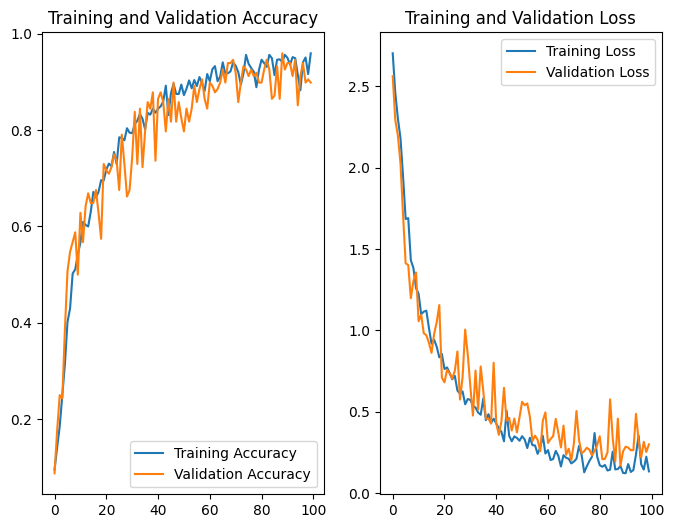

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot (range(100), acc, label='Training Accuracy')
plt.plot (range(100), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), loss, label='Training Loss')
plt.plot(range(100), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Run prediction on a sample image

First image to predict
Actual label: Tomato_Bacterial_spot
1/1 [==============================] - 0s 36ms/step
Predicted label: Tomato_Bacterial_spot


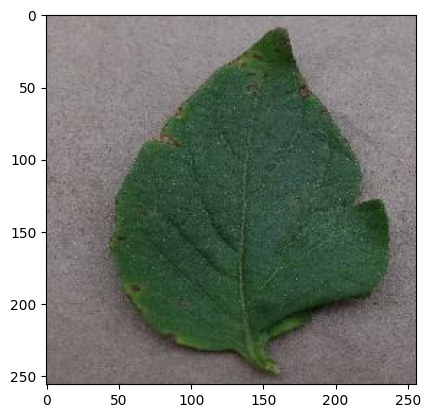

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#Write a function for inference

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


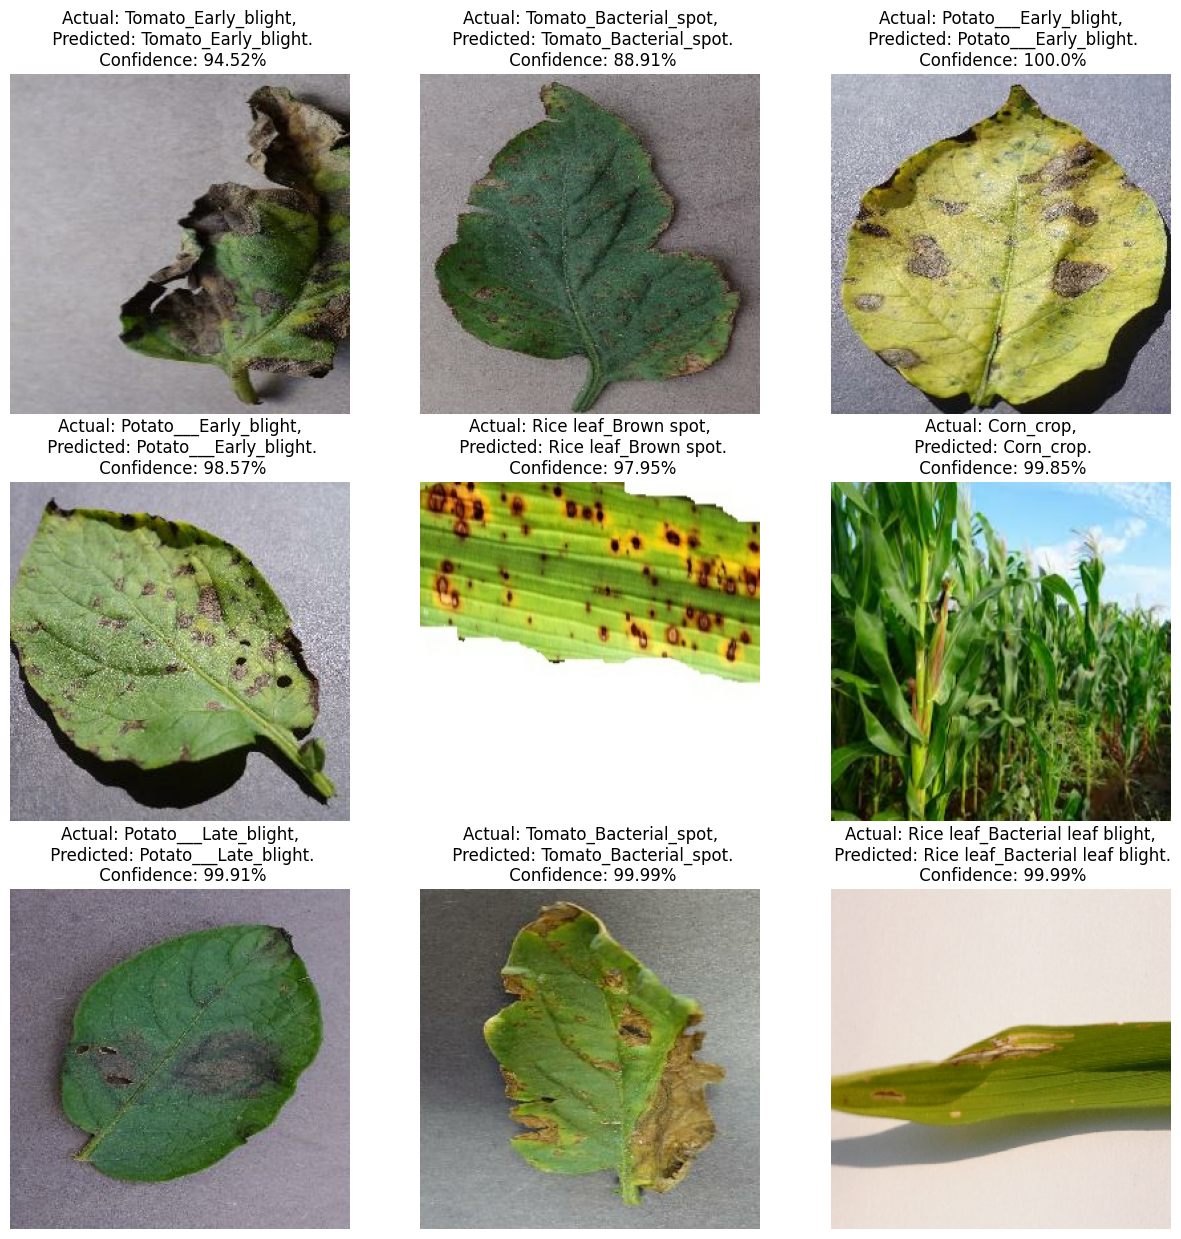

In [ ]:
#run inference on few sample images

plt.figure(figsize=(15, 15)) #image bigger
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        #print
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off") #no axis

In [ ]:
#Save model
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/savedModel/models.keras')

In [ ]:
#Convert saved model to tflite

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/savedModel/models.keras')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfliteModel = converter.convert()

# Save the model
#open('model.tflite', 'wb').write(tfliteModel)
with open('models.tflite', 'wb') as f:
    f.write(tfliteModel)
